#Анализ результатов А/B-тестирования изменений после проведения акции в сети магазинов

В компании есть рекламная акция, в рамках которой клиенту дается возможность получить дополнительные баллы лояльности за покупку, совершенную в течение ограниченного периода времени после запуска акции.

Классическая акция подразумевает получение дополнительных 1000 баллов лояльности за покупку от 100 рублей. Было решено провести эксперимент, в рамках которого в тестовой группе предлагается в 2 раза больше баллов лояльности за покупку от 100 рублей. Эксперимент был проведен в шести торговых точках.

## Загрузка библиотек

In [ ]:
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_1samp
from statsmodels.stats.power import TTestIndPower

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Обработка данных

Считываем данные из csv-файла в датафрейм и сохраняем в переменную

In [ ]:
#Подгружаем данные с гугл диска
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Dataset_AB_TEST.csv', sep=';')

Mounted at /content/drive


Изучаем общую информацию о полученном датафрейме

In [ ]:
df.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


In [ ]:
df.isna().sum()

id_client       0
id_group       74
sum_pay       127
id_point       81
months_reg      0
dtype: int64

In [ ]:
# убираем пустые значения
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_client   10840 non-null  int64  
 1   id_group    10840 non-null  object 
 2   sum_pay     10840 non-null  float64
 3   id_point    10840 non-null  float64
 4   months_reg  10840 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 508.1+ KB


In [ ]:
# меняем тип данных id_point
df = df.astype({'id_point':'int'})

In [ ]:
df.nunique()

id_client     10840
id_group          2
sum_pay        5915
id_point          6
months_reg       15
dtype: int64

In [ ]:
df.describe()

,id_client,sum_pay,id_point,months_reg
count,1.084000e+04,10840.000000,10840.000000,10840.000000
mean,1.372953e+06,3568.758026,1180.039760,4.693911
std,1.482036e+04,2927.273978,4.353995,3.174513
min,1.359000e+06,59.000000,1178.000000,0.000000
25%,1.361710e+06,1250.750000,1178.000000,2.000000
50%,1.370636e+06,3173.500000,1179.000000,4.000000
75%,1.373417e+06,5356.500000,1179.000000,6.000000
max,1.420345e+06,24797.000000,1199.000000,14.000000


Посмотрим, как распределяются данные с помощью графика boxplot

<Axes: xlabel='id_group', ylabel='sum_pay'>

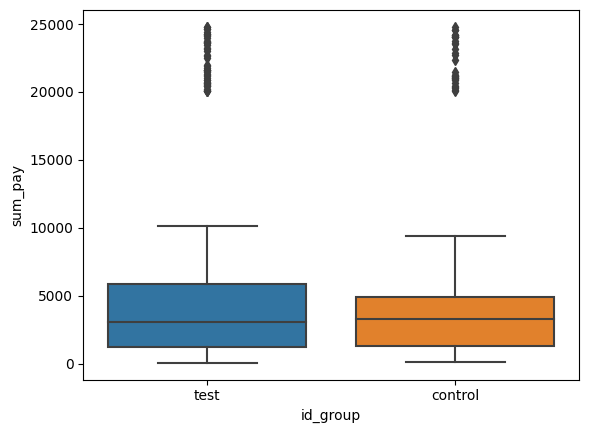

In [ ]:
sns.boxplot(x='id_group', y='sum_pay', data=df)

In [ ]:
# убираем выбросы
df = df[df['sum_pay'] < 20000]

Посмотрим распределение клиентов по группам

In [ ]:
df.id_group.value_counts()

test       5621
control    5140
Name: id_group, dtype: int64

В тестовой группе почти на 500 человек (~10%) больше, чем в контрольной.

In [ ]:
# посмотрим распределение клиентов про группам в разрезе торговых точек
df[['id_group', 'id_point', 'id_client']].groupby(['id_point', 'id_group']).count().reset_index()

,id_point,id_group,id_client
0,1178,control,2403
1,1178,test,2406
2,1179,control,1697
3,1179,test,1745
4,1182,control,1012
5,1182,test,950
6,1186,control,23
7,1186,test,40
8,1188,control,5
9,1188,test,4


В точке 1199 отсутствует контрольная группа, необходимо исключить ее из анализа.

In [ ]:
# убираем точку 1199
df = df[df['id_point'] != 1199]

In [ ]:
# повторно смотрим распределение клиентов по группам
df.id_group.value_counts()

test       5145
control    5140
Name: id_group, dtype: int64

Теперь в контрольной и в тестовой группе примерно одинаковое количество клиентов.

# Статистический анализ и проверка на нормальность распределения

H0: Данные имеют нормальное распределение.
H1: Данные не имеют нормальное распределение.

Чтобы проверить статистическую значимость различий, на первом этапе следует проверить данные на нормальность.
Если условия соблюдены, можно использовать t-тест для подтверждения различий между группами.
В противном случае можно использовать непараметрический U-критерий Манна-Уитни, для которого предположение о нормальности не требуется.

###Тест на нормальность Шапиро-Уилка

Критерий Шапиро-Уилка является наиболее эффективным критерием проверки гипотезы о принадлежности выборки к нормальному закону распределения.

Гипотезы:
H0: Данные имеют нормальное распределение.
H1: Данные не имеют нормальное распределение.

Если p-значение (p-value) ≤ 0,05, то нулевая гипотеза может быть отклонена, то есть предполагаем, что распределение данных не является нормальным.
Если p-значение (p-value) > 0,05, то нулевая гипотеза не может быть отклонена, т.е. предполагаем, что распределение данных является нормальным.

In [ ]:
shapiro(df.sum_pay)

ShapiroResult(statistic=0.9413980841636658, pvalue=0.0)

Тест Шапиро-Уилка показал, что значение p-value меньше 0,05, что означает, что мы отвергаем нулевую гипотезу. Это означает, что распределение не соответствует нормальному. Поэтому будем использовать U-критерий Манна-Уитни.

### Тест Манна-Уитни

U-критерий Манна-Уитни (иногда называемый критерием суммы рангов Уилкоксона) используется для сравнения различий между двумя независимыми выборками, когда распределение выборки не является нормальным. Он считается непараметрическим эквивалентом двухвыборочного независимого t-критерия.

Гипотезы:
H0: Между двумя группами нет существенной разницы (контрольная группа = тестовая группа).
Н1: Есть существенная разница между двумя группами (контрольная группа ≠ тестовая группа).

In [ ]:
# разделим контрольную и тестовую группы на отдельные датафреймы
control_group = df[df['id_group'] == 'control']
test_group = df[df['id_group'] == 'test']

In [ ]:
# сравним группы при помощи теста Манна-Уитни
control = control_group['sum_pay']
test = test_group['sum_pay']
test_stat, pvalue = mannwhitneyu(test, control)
print('p-value = %.4f.' % (pvalue))

p-value = 0.5725.


U-критерий Манна-Уитни показал значение p-value больше 0,05, что означает, что мы не можем отвергнуть нулевую гипотезу. **Это означает, что изменение не является статистически значимым.**

Используем метод bootstrap для сравнения средних чеков

###Bootstrap

**Bootstrap** - это статистический метод, который выполняет повторную выборку одного набора данных для создания множества смоделированных выборок. Этот процесс позволяет вычислять стандартные отклонения, строить доверительные интервалы и выполнять проверку гипотез. Основное различие между Bootstrap и статистическим тестированием заключается в том, что bootstrap можно использовать для вычисления p-значений или доверительных интервалов в любой ситуации, включая те, которые не подходят для t-тестов или любого другого известного теста.

​Этапы Bootstrap следующие:
1. Генерируем пару подвыборок того же размера из исходных данных контрольной и тестовой групп;
2. Считаем метрики для каждой из групп;
3 Вычисляем разность метрик, сохраняем полученное значение;
4. Повторяем шаги 1-3 от 1000 до 10000 раз;
5. Строим доверительный интервал с уровнем значимости alpha;

Если 0 не принадлежит ДИ, то отличия статистически значимы на уровне значимости alpha, иначе нет.

In [ ]:
!pip install bootstrapped

  Preparing metadata (setup.py) ... done
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13932 sha256=376efd5e25c27a92684cba157268ff715a4c81112e87e71c57bb69409866d826
  Stored in directory: /root/.cache/pip/wheels/63/89/c7/09fd0b2ce6a69f0b5884df971b0de884500fe20837a8a3ab7f
Successfully built bootstrapped


In [ ]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [ ]:
# подготовим данные по тесовой и контрольной группе
test = df[df['id_group'] == 'test']['sum_pay'].values
ctrl = df[df['id_group'] == 'control']['sum_pay'].values

In [ ]:
b = bs.bootstrap_ab(test = test, ctrl = ctrl, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, return_distribution=True)
b

array([169.62387192, 121.39710932, 164.92654876, ..., 192.52974253,
       134.06104431,  91.46973924])

Создаем функцию для визуализации результатов bootstrap теста.

In [ ]:
def plot_bootstrap_test(data, title):

    borders = np.percentile(data, [2.5, 97.5]) # задаем ширину 95%-ного доверительного интервала

    ax = sns.histplot(data)
    ax.set(xlabel=None, ylabel=None)

    plt.title(title, fontsize=12)
    plt.rcParams["figure.figsize"] = (10, 8)

    plt.axvline(0, # рисуем линию на уровне ноля
               ymin=0,
               ymax=0.5,
               linestyle='--',
               color='red')

    plt.axvline(borders[0], # рисуем линию в начале доверительного интервала
               ymin=0,
               ymax=0.5,
               linestyle='--',
               color='grey',
               label='95%-доверительный интервал')

    plt.axvline(borders[1], # рисуем линию в конце доверительного интервала
               ymin=0,
               ymax=0.5,
               linestyle='--',
               color='grey')

    plt.legend(loc="upper right")

    plt.show()

Визуализируем результат при помощи созданной функции.

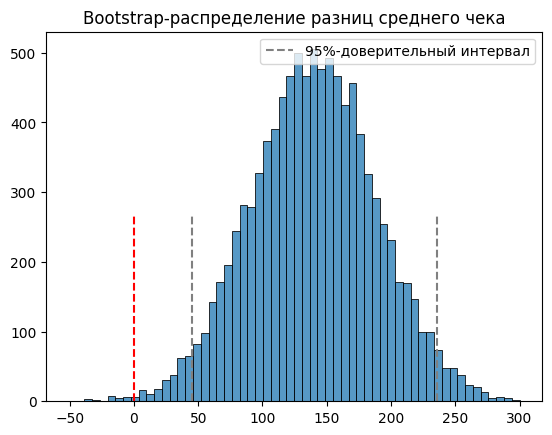

In [ ]:
plot_bootstrap_test(data=b,
                    title='Bootstrap-распределение разниц среднего чека')

Для разницы средних чеков между контрольной и тестовой группами мы определили 95% доверительный интервал.
Поскольку 0 не попадает в доверительный интервал, мы можем сказать, что разница между средними чеками в контрольной и тестовой группах статистически значимая. Мы видим, что средний чек в тестовой группе увеличился.

###Расчет мощности

**Мощность теста** - вероятность увидеть разницу там, где она действительно существует.

Обычно берется мощность 80% или выше, то есть в востмидесяти случаях из ста мы будем способны разглядеть разницу там, где она есть. Если мощность низкая, то эксперимент будет страдать от высокой частоты ложных отрицательных результатов (ошибка второго типа).

Размер эффекта обычно представляет собой разницу в средних между контрольной и тестовой группами, деленную на стандартное отклонение.

In [ ]:
# рассчитаем средние в группах
C_mean = control_group.sum_pay.values.mean()
T_mean = test_group.sum_pay.values.mean()

# рассчитаем стандартные отклонения в группах
C_std = control_group.sum_pay.values.std()
T_std = test_group.sum_pay.values.std()

In [ ]:
# посмотрим количество наблюдений в группах
print(len(control_group.sum_pay.values), len(test_group.sum_pay.values))

5140 5145


In [ ]:
n =  len(control_group.sum_pay.values) # т.к. количество наблюдений в группах практически одинаковое, можно взять минимальное

In [ ]:
# рассчитаем standard deviation pooled
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [ ]:
# рассчитаем размер эффекта
effect =float((T_mean-C_mean)/ S)

In [ ]:
# параметры для анализа мощности
alpha = 0.05

# вычисление мощности теста
power_analysis = TTestIndPower()
result = power_analysis.solve_power(effect, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.8141374728354869

Мощность теста довольно высокая, что позволяет делать достоверные выводы.

### Анализ  по торговым точкам

In [ ]:
# посмотрим распределение клиентов про группам в разрезе торговых точек
df[['id_group', 'id_point', 'id_client']].groupby(['id_point', 'id_group']).count().reset_index()

,id_point,id_group,id_client
0,1178,control,2403
1,1178,test,2406
2,1179,control,1697
3,1179,test,1745
4,1182,control,1012
5,1182,test,950
6,1186,control,23
7,1186,test,40
8,1188,control,5
9,1188,test,4


В точке 1199 отсутствует контрольная группа, количество клиетов в точках 1186 и 1188 меньше 30, поэтому проведем исследование в разрезе точек продаж 1178, 1179 и 1182 с помощью bootstrap

In [ ]:
df_point = df[df['id_point'] == 1178]
test = df_point[df_point['id_group'] == 'test']['sum_pay'].values
control = df_point[df_point['id_group'] == 'control']['sum_pay'].values

In [ ]:
b = bs.bootstrap_ab(test, control, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, return_distribution=True)
b

array([  17.56770216,  -38.40295433, -131.43944498, ...,  -64.04911981,
       -112.00476545, -140.43867495])

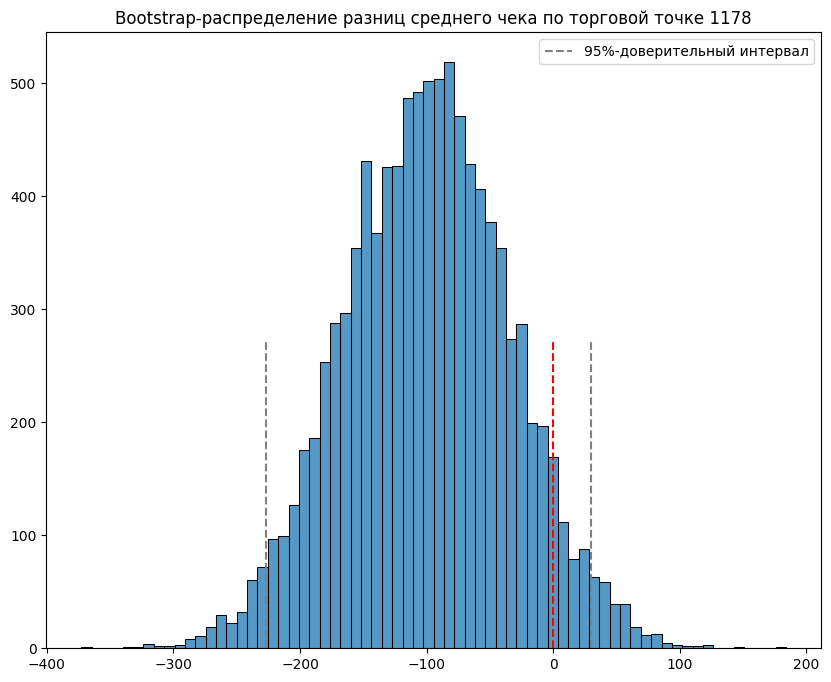

In [ ]:
plot_bootstrap_test(data=b,
                    title='Bootstrap-распределение разниц среднего чека по торговой точке 1178')

In [ ]:
df_point = df[df['id_point'] == 1179]
test = df_point[df_point['id_group'] == 'test']['sum_pay'].values
control = df_point[df_point['id_group'] == 'control']['sum_pay'].values

In [ ]:
b = bs.bootstrap_ab(test, control, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, return_distribution=True)
b

array([ 82.52606302, 134.81091459,  25.73447665, ..., 143.88218481,
       105.28572519, 132.32143898])

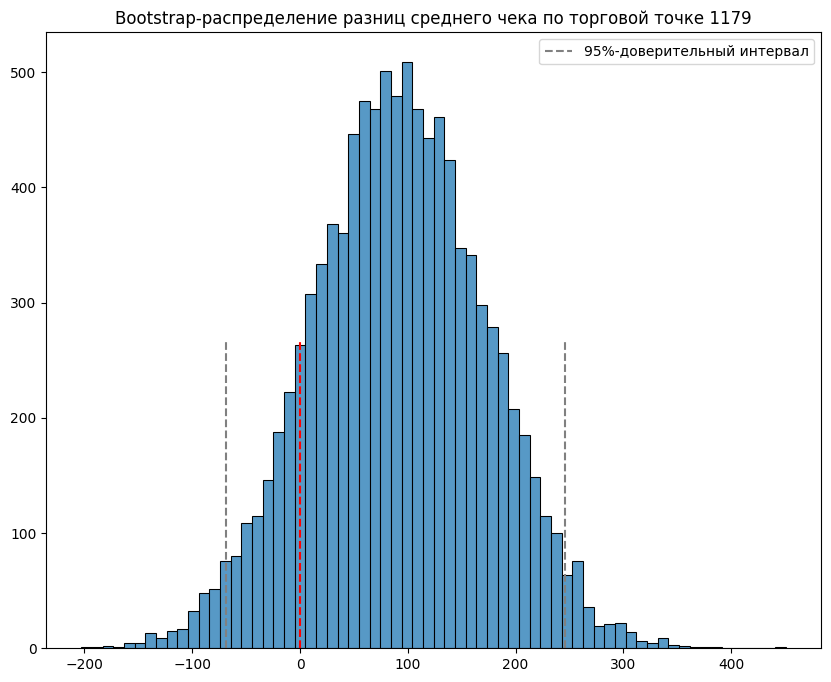

In [ ]:
plot_bootstrap_test(data=b,
                    title='Bootstrap-распределение разниц среднего чека по торговой точке 1179')

In [ ]:
df_point = df[df['id_point'] == 1182]
test = df_point[df_point['id_group'] == 'test']['sum_pay'].values
control = df_point[df_point['id_group'] == 'control']['sum_pay'].values

In [ ]:
b = bs.bootstrap_ab(test, control, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, return_distribution=True)
b

array([ 706.93250884,  885.91563553,  765.27108384, ...,  947.65707718,
        927.79189931, 1082.47348034])

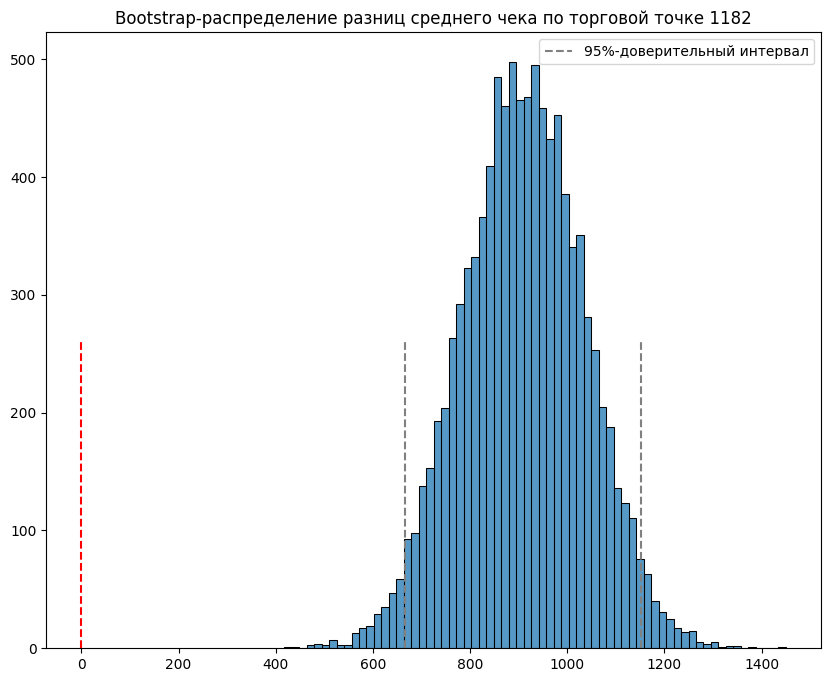

In [ ]:
plot_bootstrap_test(data=b,
                    title='Bootstrap-распределение разниц среднего чека по торговой точке 1182')

в разрезе торговых точек видно, что в точках 1178 и 1179 разница в среднем чеке не имеет статистической значимости. В точке 1182 разница средних чеков выросла и она статистически значима.

# Итоги теста и рекомендации

Для получения корректных результатов необходима правильная подготовка данных, поэтому в начале мы преобразовали данные:
- убрали пустые значения
- изменили тип данных столбца id_point на int
- удалили выбросы
- исключили из анализа точку продаж, в которой отсутствует контрольная группа.


Результаты AB тестирования по всем торговым точкам показывают, что начисление дополнительных 1000 баллов в рамках проведения акции, позволило увеличить средний чек.

В разрезе торговых точек видно, что в точках 1178 и 1179 разница в среднем чеке не имеет статистической значимости. В точке 1182 разница средних чеков составила примерно 910 рублей и она статистически значима. Таким образом весь наблюдаемый на общих по всем точкам данных эффект обусловлен одной этой точкой продаж. По точке 1199 отсутсвует контрольная группа. По точкам 1186 и 1188 недостаточно данных для анализа. Для того, чтобы сделать выводы, следует перезапустить тест.